In [20]:
import matplotlib.pylab as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time
import sys
import os

import seaborn as sns
import gensim

import django
import platform

if platform.node() == "srv-mcc-apsis":
    sys.path.append('/home/muef/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/Documents/Data/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
from parliament.tasks import do_search, run_tm
import cities.models as cmodels
from django.contrib.auth.models import User
from tmv_app.models import *
from utils.tm_mgmt import update_topic_scores
from utils.text import *
from django.db.models import Q, Count, Func, F, Sum, Value, Case, When, IntegerField

from tmv_app.utils.plotting import plot_tsne

# party positions in topic space (tsne)

In [14]:
run_id = 2350

save_dir = "./tsne_results/".format(run_id)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

stat = RunStats.objects.get(run_id=run_id)

#stat.dt_matrix(save_dir, force_overwrite=True)

In [15]:
perplexity = 10
# https://distill.pub/2016/misread-tsne/

#stat.dt_matrix(save_dir, force_overwrite=True)

tsne_results, r_ind = stat.calculate_tsne(save_dir, perplexity) #, force_overwrite=True)
tsne_results, r_ind

We've already calculated the required matrices!
We've already calculated the tsne positions


(array([[-17.65141262, -19.95958419],
        [-36.72234363, -15.13299024],
        [ 32.50572037,  36.99428651],
        ...,
        [-15.03923667,  13.06431606],
        [ 25.05107187,  12.02027767],
        [-22.97129277,   2.55042649]]),
 array([3342338, 2818065, 3211282, ..., 3112937, 2064374, 3309563]))

In [3]:
doctopicmatrix = np.load('tsne_results/run_2111_s_0_m.npy')
doctopicmatrix[()].toarray()

array([[8.33688388, 0.01      , 0.01      , ..., 0.01      , 0.01      ,
        0.01      ],
       [0.01      , 8.03591896, 0.01      , ..., 0.01      , 0.01      ,
        0.01      ],
       [0.01      , 0.01      , 0.01      , ..., 0.01      , 0.01      ,
        0.01      ],
       ...,
       [0.01      , 0.01      , 0.01      , ..., 0.01      , 0.01      ,
        0.01      ],
       [0.01      , 0.01      , 0.01      , ..., 0.01      , 0.01      ,
        0.01      ],
       [0.01      , 0.01      , 0.01      , ..., 0.01      , 0.01      ,
        0.01      ]])

In [18]:
res = np.load('tsne_results/run_2111_s_0_p_10_results.npy')
res

array([[nan, nan]])

In [21]:
# copied from max for category attribution

party_color_dict = {"afd": "#0088FF", "cducsu": "#000000", "fdp": "#FFED00", "gruene": "#64A12D",
                    "linke": "#8C3473", "spd": "#EB001F", "other": "grey"}

no_party_ids = r_ind

party_cats = [
    {'party': 'cducsu'},
    {'party': 'fdp'},
    {'party': 'gruene'},
    {'party': 'linke'},
    {'party': 'spd'},
]

#oecd_df = pd.DataFrame()

for i, c in enumerate(party_cats):
    party = c['party']
    uts = pm.Utterance.objects.filter(search_matches=stat.psearch, speaker__party__name=party).values_list('id', flat=True)
    c['docs'] = list(set(uts) & set(r_ind))
    #oecd_df = pd.concat([oecd_df,pd.DataFrame({
    #    "oecd": c['wc__oecd'], "doc": c['docs']
    #})])
    c['n_docs'] = len(c['docs'])
    c['name'] = party
    # assign color to the category
    c['color'] = party_color_dict[party]
    c['dis'] = np.argwhere(np.isin(r_ind,c['docs']))
    no_party_ids = no_party_ids[np.isin(no_party_ids,c['docs'],invert=True)]
    
from operator import itemgetter
party_cats = sorted(party_cats, key=itemgetter('n_docs'), reverse=True)


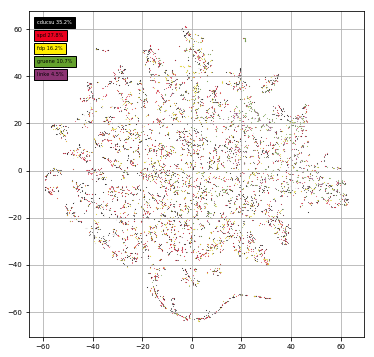

In [25]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_tsne(r_ind, tsne_results, party_cats, no_party_ids, ax=ax)
fig.savefig(os.path.join(save_dir, 'tsne_plot_parties_run_{}.png'.format(run_id)), dpi=150, bbox_inches="tight")

In [26]:
cmap = plt.cm.viridis  # define the colormap: e.g. viridis or jet
norm = mpl.colors.Normalize(vmin=1.,vmax=19.)
# extract all colors from the .jet map
color_list = [cmap(norm(i)) for i in range(1,20)]

no_party_ids = r_ind

pp_cats = [{'period': i} for i in range(1, 20)]

for i, c in enumerate(pp_cats):
    pp = c['period']
    uts = pm.Utterance.objects.filter(search_matches=stat.psearch, document__parlperiod__n=pp).values_list('id', flat=True)
    c['docs'] = list(set(uts) & set(r_ind))
    c['n_docs'] = len(c['docs'])
    c['name'] = str(pp)
    # assign color to the category
    c['color'] = color_list[i]
    c['dis'] = np.argwhere(np.isin(r_ind,c['docs']))
    
from operator import itemgetter
pp_cats = sorted(pp_cats, key=itemgetter('n_docs'), reverse=True)

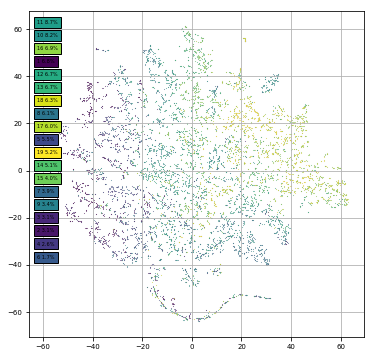

In [27]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_tsne(r_ind, tsne_results, pp_cats, [], ax=ax)
fig.savefig(os.path.join(save_dir, 'tsne_plot_parlperiods_run_{}.png'.format(run_id)), dpi=150, bbox_inches="tight")

# compress folder to easily download it

In [ ]:
%%bash
zip -r plots/topic_analysis_2111.zip plots/topic_analysis_2111/